# F20DL Lab 11

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import tensorflow as tf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

In [2]:
# Load the dataset into numpy arrays
X = np.load("./datasets/smiley_X_new.npy")
y = np.load("./datasets/smiley_Y_new.npy")

In [3]:
# X is a list of all images. Images are represented as columns of pixel values.
# To get pixel (r, c) of image i, use X[i][r-1][c-1][0]

# X[0] returns columns of pixel values representing the 1st image.
# X[0][2][6][0] returns the value of the pixel in the 3rd row and 7th column of the 1st image (r=3, c=7).
# y[0] returns the label for the 1st image. (0 = happy, 1 = sad)

In [4]:
# Shows smiley as an image. 'smiley' should be an element in 'X'
def show_smiley(smiley):
    plt.figure(figsize=(1,1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(smiley, cmap="Greys")

In [5]:
class_names = ["happy", "sad"]

## Convolutional Neural Networks

### CNN 0

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 6384, Testing samples: 2736


In [7]:
cnn0 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])
cnn0_weights = cnn0.get_weights()

cnn0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [8]:
cnn0.fit(X_train, y_train, epochs=5)

Epoch 1/5
200/200 [==============================] - 9s 33ms/step - loss: 0.2791 - accuracy: 0.8737
Epoch 2/5
200/200 [==============================] - 6s 30ms/step - loss: 0.1039 - accuracy: 0.9319
Epoch 3/5
200/200 [==============================] - 5s 26ms/step - loss: 0.0967 - accuracy: 0.9341
Epoch 4/5
200/200 [==============================] - 6s 31ms/step - loss: 0.0956 - accuracy: 0.9323
Epoch 5/5
200/200 [==============================] - 6s 30ms/step - loss: 0.0943 - accuracy: 0.9342


In [9]:
test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.932748556137085


In [10]:
y_pred0 = cnn0.predict(X_test)

86/86 [==============================] - 1s 5ms/step


Prediction:  happy


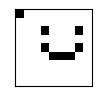

In [11]:
# Prediction for first testing image
print("Prediction: ", class_names[np.argmax(y_pred0[0])])
show_smiley(X_test[0])

In [12]:
# Reference: https://stackoverflow.com/a/43957826
def reset_weights(model, weights):
    model.set_weights(weights)

## Experimenting with Different Architectures

In [13]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=5, validation_split=0.3)

Epoch 1/5
45/45 [==============================] - 2s 45ms/step - loss: 0.0928 - accuracy: 0.9364 - val_loss: 0.0891 - val_accuracy: 0.9353
Epoch 2/5
45/45 [==============================] - 1s 31ms/step - loss: 0.0926 - accuracy: 0.9355 - val_loss: 0.0899 - val_accuracy: 0.9306
Epoch 3/5
45/45 [==============================] - 3s 76ms/step - loss: 0.0931 - accuracy: 0.9362 - val_loss: 0.0900 - val_accuracy: 0.9311
Epoch 4/5
45/45 [==============================] - 4s 89ms/step - loss: 0.0923 - accuracy: 0.9373 - val_loss: 0.0901 - val_accuracy: 0.9395
Epoch 5/5
45/45 [==============================] - 3s 55ms/step - loss: 0.0931 - accuracy: 0.9344 - val_loss: 0.0904 - val_accuracy: 0.9290


In [14]:
cnn0.fit(x=X_train, y=y_train, batch_size=64, epochs=5, validation_split=0.3)

Epoch 1/5
70/70 [==============================] - 3s 36ms/step - loss: 0.0925 - accuracy: 0.9373 - val_loss: 0.0900 - val_accuracy: 0.9342
Epoch 2/5
70/70 [==============================] - 3s 36ms/step - loss: 0.0916 - accuracy: 0.9389 - val_loss: 0.0931 - val_accuracy: 0.9295
Epoch 3/5
70/70 [==============================] - 2s 28ms/step - loss: 0.0933 - accuracy: 0.9362 - val_loss: 0.0899 - val_accuracy: 0.9342
Epoch 4/5
70/70 [==============================] - 3s 37ms/step - loss: 0.0934 - accuracy: 0.9378 - val_loss: 0.0934 - val_accuracy: 0.9327
Epoch 5/5
70/70 [==============================] - 2s 34ms/step - loss: 0.0927 - accuracy: 0.9367 - val_loss: 0.0903 - val_accuracy: 0.9327


In [15]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=5, validation_split=0.5)

Epoch 1/5
32/32 [==============================] - 2s 65ms/step - loss: 0.0889 - accuracy: 0.9361 - val_loss: 0.0936 - val_accuracy: 0.9301
Epoch 2/5
32/32 [==============================] - 3s 94ms/step - loss: 0.0890 - accuracy: 0.9395 - val_loss: 0.0941 - val_accuracy: 0.9283
Epoch 3/5
32/32 [==============================] - 2s 63ms/step - loss: 0.0889 - accuracy: 0.9398 - val_loss: 0.0946 - val_accuracy: 0.9320
Epoch 4/5
32/32 [==============================] - 1s 41ms/step - loss: 0.0890 - accuracy: 0.9395 - val_loss: 0.0943 - val_accuracy: 0.9320
Epoch 5/5
32/32 [==============================] - 2s 64ms/step - loss: 0.0892 - accuracy: 0.9405 - val_loss: 0.0945 - val_accuracy: 0.9289


In [16]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=5, validation_split=0.2)

Epoch 1/5
52/52 [==============================] - 3s 60ms/step - loss: 0.0909 - accuracy: 0.9375 - val_loss: 0.0937 - val_accuracy: 0.9319
Epoch 2/5
52/52 [==============================] - 2s 31ms/step - loss: 0.0915 - accuracy: 0.9369 - val_loss: 0.0947 - val_accuracy: 0.9256
Epoch 3/5
52/52 [==============================] - 2s 43ms/step - loss: 0.0922 - accuracy: 0.9379 - val_loss: 0.0941 - val_accuracy: 0.9295
Epoch 4/5
52/52 [==============================] - 3s 52ms/step - loss: 0.0908 - accuracy: 0.9369 - val_loss: 0.0927 - val_accuracy: 0.9342
Epoch 5/5
52/52 [==============================] - 3s 62ms/step - loss: 0.0912 - accuracy: 0.9366 - val_loss: 0.0932 - val_accuracy: 0.9280


### Optimiser = SGD (Defaults: Learning Rate = 0.001, Momentum = 0)

In [17]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(), 
             loss="sparse_categorical_crossentropy", 
             metrics=["accuracy"])
cnn0.fit(X_train, y_train, epochs=5)

test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)

Epoch 1/5
200/200 [==============================] - 9s 36ms/step - loss: 0.6884 - accuracy: 0.5866
Epoch 2/5
200/200 [==============================] - 6s 31ms/step - loss: 0.6730 - accuracy: 0.7669
Epoch 3/5
200/200 [==============================] - 6s 29ms/step - loss: 0.6508 - accuracy: 0.8371
Epoch 4/5
200/200 [==============================] - 5s 27ms/step - loss: 0.6143 - accuracy: 0.8852
Epoch 5/5
200/200 [==============================] - 6s 28ms/step - loss: 0.5491 - accuracy: 0.9001

Test accuracy: 0.8983917832374573


### Optimiser = SGD, Learning Rate = 0.01, Momentum = 0.9

In [18]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
             loss="sparse_categorical_crossentropy", 
             metrics=["accuracy"])
cnn0.fit(X_train, y_train, epochs=5)

test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)

Epoch 1/5
200/200 [==============================] - 7s 27ms/step - loss: 0.5394 - accuracy: 0.7688
Epoch 2/5
200/200 [==============================] - 6s 28ms/step - loss: 0.1383 - accuracy: 0.9300
Epoch 3/5
200/200 [==============================] - 6s 29ms/step - loss: 0.1057 - accuracy: 0.9323
Epoch 4/5
200/200 [==============================] - 6s 30ms/step - loss: 0.0974 - accuracy: 0.9339
Epoch 5/5
200/200 [==============================] - 5s 25ms/step - loss: 0.0976 - accuracy: 0.9330

Test accuracy: 0.9290935397148132


### Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.9

In [19]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), 
             loss="sparse_categorical_crossentropy", 
             metrics=["accuracy"])
cnn0.fit(X_train, y_train, epochs=5)

test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)

Epoch 1/5
200/200 [==============================] - 9s 39ms/step - loss: 0.2273 - accuracy: 0.8553
Epoch 2/5
200/200 [==============================] - 2s 12ms/step - loss: 0.0933 - accuracy: 0.9339
Epoch 3/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0941 - accuracy: 0.9330
Epoch 4/5
200/200 [==============================] - 3s 16ms/step - loss: 0.0929 - accuracy: 0.9323
Epoch 5/5
200/200 [==============================] - 6s 29ms/step - loss: 0.0927 - accuracy: 0.9355

Test accuracy: 0.932748556137085


### Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.5

In [20]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5), 
             loss="sparse_categorical_crossentropy", 
             metrics=["accuracy"])
cnn0.fit(X_train, y_train, epochs=5)

test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)

Epoch 1/5
200/200 [==============================] - 5s 17ms/step - loss: 0.3403 - accuracy: 0.8285
Epoch 2/5
200/200 [==============================] - 6s 28ms/step - loss: 0.1024 - accuracy: 0.9311
Epoch 3/5
200/200 [==============================] - 6s 29ms/step - loss: 0.0960 - accuracy: 0.9319
Epoch 4/5
200/200 [==============================] - 6s 29ms/step - loss: 0.0940 - accuracy: 0.9361
Epoch 5/5
200/200 [==============================] - 6s 29ms/step - loss: 0.0935 - accuracy: 0.9322

Test accuracy: 0.932748556137085
